# Maximum Likelihood Estimate of an Exponential Constant

Generate a set of values according to the exponential PDF

$$
p(t|\tau) = \frac{1}{\tau} e^{-t/\tau}.
$$

Then maximize the log likelihood to find the best estimator $\hat{\tau}$.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from tqdm.notebook import tqdm

from IPython.display import display, Markdown

In [2]:
mpl.rc('font', size=18)

## Define the Likelihood Function

Use the definition of a log-likelihood for I.I.D. exponential data $\{t_i\}$.

$$
\ln{\mathcal{L}} = -\sum_{i=1}^N \left(\ln{\tau} + \frac{t_i}{\tau}\right)
$$

In [3]:
loglike = lambda t_i, tau: -np.sum(np.log(tau) + t_i/tau)

## Generate Data and Fit the Constant $\tau$

Produce $n$ random exponential values with $\tau=1$.

In [4]:
n = 50  # Generate n times {t_i}
tau = 1.

np.random.seed(1234)
t = np.random.exponential(tau, n) # Generate n times distributed as ~exp(t/tau).

Find the best fit using the [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function from the `scipy.optimize` library. Some comments:

1. We actually need to use $-ln{\mathcal{L}}$ since we are calling a minimizer.
1. We'll use the `BFGS` algorithm since it computes the Hessian matrix, giving the uncertainty on $\hat{\tau}$.

In [5]:
# Note that because we call -ln(L) in a minimizer, the first argument
# has to be the array of function parameters (see minimize documentation).
nloglike = lambda p, t: -loglike(t, p[0])

# Minimize using BFGS. Uncertainty is negative inv sqrt of the Hessian.
p0 = [0.7]
res = minimize(nloglike, p0, args=(t), method='BFGS')
tau_best = res.x[0]
tau_best_err = np.sqrt(res.hess_inv[0,0])

# Print output.
display(Markdown(rf'$\hat{{\tau}} = {tau_best:.2f} \pm {tau_best_err:.2f}$'))

$\hat{\tau} = 0.96 \pm 0.14$

## Compute $\hat{\tau}$ using the $\Delta\ln{\mathcal{L}}=1/2$ Rule

Using the data we just generated, find $\hat{\tau}$ by maximizing $\ln{\mathcal{L}}$. To do this, compute $\ln{\mathcal{L}}$ on a dense grid of values $\tau$ and identify the maximum.

Then, compute the values of $\tau$ where $\ln{\mathcal{L}}$ decreases by $1/2$ from its maximum value. These will define the central 68\% confidence interval on $\hat{\tau}$.

Notice that when $N$ is small, this procedure will produce asymmetric error bars.

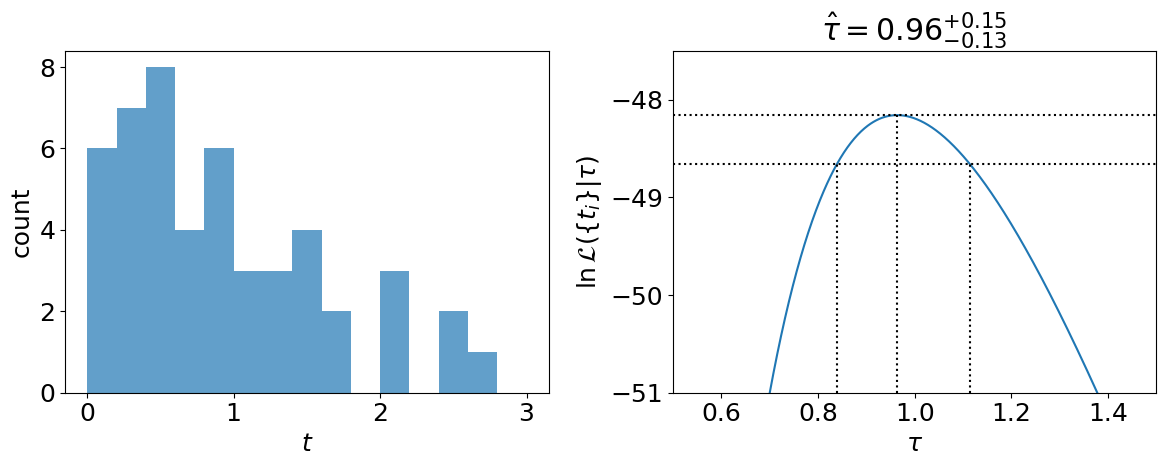

In [6]:
fig, axes = plt.subplots(1,2, figsize=(12,5), tight_layout=True)

# Plot a histogram of times {t_i}.
ax = axes[0]
ax.hist(t, bins=np.linspace(0,3,16), alpha=0.7)
ax.set(xlabel='$t$',
       ylabel='count')

# Evaluate ln(L) on a dense grid of values tau surrounding the best fit.
tau_grid = np.arange(0.5, 1.5, 0.001)
n_grid = len(tau_grid)
logl_grid = [loglike(t, tau_) for tau_ in tau_grid]

# Compute the location tau_max where ln(L) is a maximum.
i = np.argmax(logl_grid)
tau_max = tau_grid[i]
logl_max = logl_grid[i]

# Compute the positions tau_lo and tau_up where ln(L) drops by 0.5 from
# the maximum likelihood value.
j = np.argmin(np.abs(logl_grid[0:i] - (logl_max - 0.5)))
k = i + np.argmin(np.abs(logl_grid[i:] - (logl_max - 0.5)))
tau_lo = tau_grid[j]
tau_up = tau_grid[k]
dtau_lo = tau_max - tau_lo
dtau_up = tau_up - tau_max

# Plot the results, using some reasonable values for the min/max axis limits.
ymax = np.ceil(logl_max) + 0.5
ymin = ymax - 3.5
xmin, xmax = tau_grid[0], tau_grid[-1]

ax = axes[1]
ax.plot(tau_grid, logl_grid)

ax.hlines(logl_max, xmin, xmax, ls=':', color='k')
ax.hlines(logl_max - 0.5, xmin, xmax, ls=':', color='k')

ax.vlines(tau_max, ymin, logl_max, ls=':', color='k')
ax.vlines(tau_lo,  ymin, logl_max-0.5, ls=':', color='k')
ax.vlines(tau_up, ymin,  logl_max-0.5, ls=':', color='k')

ax.set(xlim=(xmin, xmax),
       xlabel=r'$\tau$',
       ylim=(ymin, ymax),
       ylabel=r'$\ln{\mathcal{L}}(\{t_i\}|\tau)$',
       title=r'$\hat{{\tau}}={:.2f}^{{+{:.2f}}}_{{-{:.2f}}}$'.format(tau_max, dtau_up, dtau_lo));

## Evaluate $\tau$ using a Monte Carlo Approach

Here we are going to generate 50,000 random exponentially distributed data sets $\{t_i\}$ with $n$ values per data set. For each data set, compute the best fit $\hat{\tau}$. Then histogram all 50,000 values of $\hat{\tau}$ and look at the central 68\% of the distribution. 

In [7]:
np.random.seed(1234)

tau_best = []
n_trials = 50000
for i in tqdm(range(0, n_trials)):
    t = np.random.exponential(1., 50)
    p0 = [1.]
    res = minimize(nloglike, p0, args=(t), method='Nelder-Mead')
    if res.success:
        tau_best.append(res.x[0])

pct = np.percentile(tau_best, [16, 50, 84])
print(pct)

  0%|          | 0/50000 [00:00<?, ?it/s]

[0.85859375 0.99316406 1.140625  ]


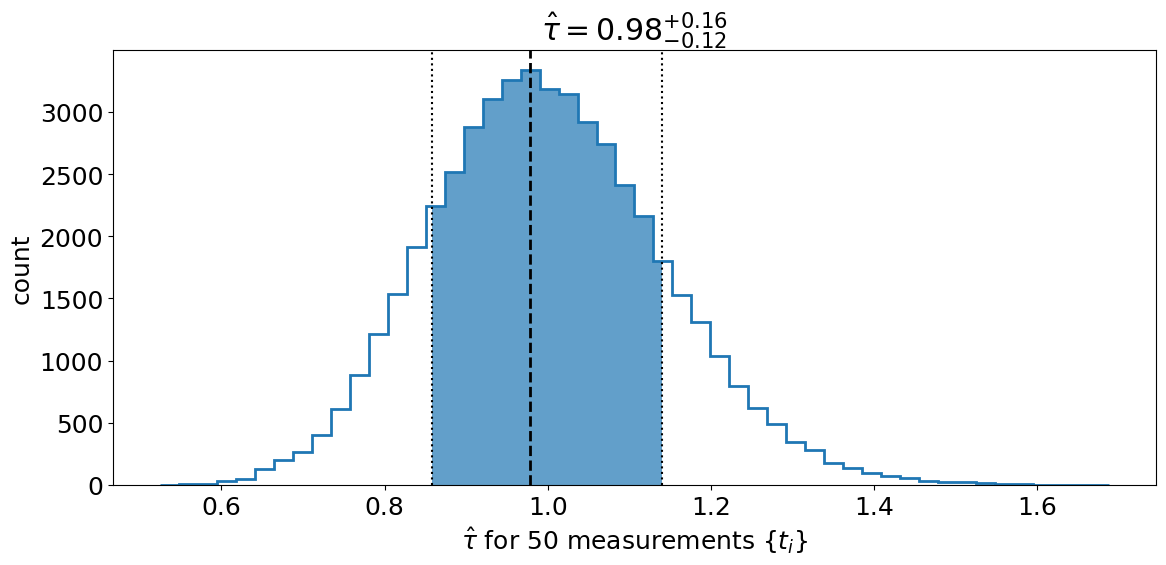

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,6), tight_layout=True)

cmap = plt.get_cmap("tab10")

# Histogram the best-fit values from the MC datasets.
count, edges, p = ax.hist(tau_best, bins=50, histtype='step', lw=2)
i = np.argmax(count)
tau_max = 0.5*(edges[i] + edges[i+1])
tau_lo = pct[0]
tau_up = pct[2]
dtau_lo = tau_max - tau_lo
dtau_up = tau_up - tau_max

# Color the central 68% interval.
for e0,e1,n_ in zip(edges[:-1], edges[1:], count):
    if e0 > pct[0] and e1 < pct[2]:
        ax.bar(e0, n_, align='edge', width=e1-e0, alpha=0.7, color=cmap(0))
    if e0 < pct[0] < e1:
        ax.bar(pct[0], n_, align='edge', width=e1-pct[0], alpha=0.7, color=cmap(0))
    if e0 < pct[2] < e1:
        ax.bar(e0, n_, align='edge', width=pct[2]-e0, alpha=0.7, color=cmap(0))

ax.axvline(pct[0], color='k', ls=':')
ax.axvline(tau_max, color='k', ls='--', lw=2)
ax.axvline(pct[2], color='k', ls=':')

ax.set(xlabel=rf'$\hat{{\tau}}$ for {n} measurements {{$t_i$}}',
       ylabel='count',
       title=rf'$\hat{{\tau}}={tau_max:.2f}^{{+{dtau_up:.2f}}}_{{-{dtau_lo:.2f}}}$');